# Project Objective

The objective of this analysis is to uncover patterns in student graduation, churn, retention, and re-enrollment behaviors by examining distributions across two key segmented groupings: **Learner Milestones** and **Reengagement Dynamics**. These groupings are defined as follows:

### Learner Milestones:
Based on the number of courses completed:
- **Unfinished Learner:** 0 courses completed  
- **Single-Course Learner:** 1 course completed  
- **Second-Course Learner:** 2 courses completed  
- **Three-Course Learner:** 3 courses completed  
- **Advanced Learner:** 4 or more courses completed  

### Reengagement Dynamics:
Based on the time between student activities:
- **No Re-enrollment:** `days_till_next_activity` is NULL and `student_status` is not "Enrolled"  
- **Fast Movers:** `days_till_next_activity` ≤ 30  
- **Intermediate Movers:** `days_till_next_activity` between 31 and 90  
- **Slow Movers:** `days_till_next_activity` > 90  
- **Currently Enrolled:** All other cases  

By identifying trends and potential blockers within these segments, the analysis aims to provide actionable insights to develop tailored interventions and strategies. The ultimate goal is to enhance student outcomes by addressing specific needs of each learner and re-engagement category, promoting retention, reducing churn, and increasing re-enrollments through curated solutions.

The dataset used for this analysis was sourced from **Kaggle**. 


In [38]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, text
import redshift_connector
import os
import boto3
from io import BytesIO
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

In [42]:
data = = pd.read_csv("Students")

In [43]:
len(data)

87094

In [44]:
# Creating a function to calculate the distribution of categorical variables within each group
def calculate_distribution(group_by_column, distribution_columns):
    distributions = {}
    for column in distribution_columns:
        grouped = data.groupby(group_by_column)[column].value_counts(normalize=True).unstack(fill_value=0)
        distributions[column] = grouped
    return distributions

# Specifying columns for the distribution analysis
distribution_columns = ['level', 'function', 'industry', 'true_student_status', 'duration']

# Calculating distribution for learner milestones
milestones_distribution = calculate_distribution('learner_milestones', distribution_columns)



In [45]:
# Displaying the distribution for 'function', 'industry', and 'true_student_status'
level_distribution = milestones_distribution['level']
function_distribution = milestones_distribution['function']
industry_distribution = milestones_distribution['industry']
true_student_status_distribution = milestones_distribution['true_student_status']

level_distribution,function_distribution, industry_distribution, true_student_status_distribution


(level                             C-Level  C-Level (CEO, COO, CTO, etc.)  \
 learner_milestones                                                         
 Advanced Learner       0.076638  0.000000                       0.006426   
 Second-Course Learner  0.131228  0.000068                       0.009896   
 Single-Course Learner  0.321157  0.000000                       0.010726   
 Three-Course Learner   0.109870  0.000000                       0.008295   
 Unfinished Learner     0.431314  0.000000                       0.010583   
 
 level                  Individual Contributor     Other  \
 learner_milestones                                        
 Advanced Learner                     0.136784  0.000095   
 Second-Course Learner                0.117197  0.000000   
 Single-Course Learner                0.113426  0.000000   
 Three-Course Learner                 0.118334  0.000000   
 Unfinished Learner                   0.009753  0.000000   
 
 level                  Senior Direct

## Learner Milestones Analysis

### Professional Level Distribution
- **Advanced Learner**:
  - **Senior Manager/Manager**: 55.75%
  - **Senior Director/Director**: 22.60%
  - **Individual Contributor**: 14.81%
  - **Vice President**: 6.12%
  - **C-Level (CEO, COO, CTO, etc.)**: 0.70%
- **Second-Course Learner**:
  - **Senior Manager/Manager**: 55.15%
  - **Senior Director/Director**: 22.77%
  - **Vice President**: 7.44%
  - **Individual Contributor**: 13.49%
  - **C-Level (CEO, COO, CTO, etc.)**: 1.14%
- **Single-Course Learner**:
  - **Senior Manager/Manager**: 50.16%
  - **Senior Director/Director**: 24.37%
  - **Individual Contributor**: 16.71%
  - **Vice President**: 7.18%
  - **C-Level (CEO, COO, CTO, etc.)**: 1.58%
- **Three-Course Learner**:
  - **Senior Manager/Manager**: 47.38%
  - **Senior Director/Director**: 32.90%
  - **Individual Contributor**: 13.29%
  - **Vice President**: 5.49%
  - **C-Level (CEO, COO, CTO, etc.)**: 0.93%
- **Unfinished Learner**:
  - **Senior Manager/Manager**: 70.66%
  - **Senior Director/Director**: 19.89%
  - **Individual Contributor**: 1.72%
  - **Vice President**: 5.87%
  - **C-Level (CEO, COO, CTO, etc.)**: 1.86%

### Function Distribution
- Functions such as **Operations**, **General Management**, and **Sales & Service** are prominently represented across all milestones.

### Industry Distribution
- **Business Services**, **Manufacturing**, and **Technology** are significant across all milestones, with **Healthcare and Pharma** being notably engaged in the "Three-Course Learner" group.

### True Student Status (Graduation Rate)
- **Advanced Learner**:
  - **Graduated**: 84.31%
  - **Dropped Out**: 12.78%
- **Second-Course Learner**:
  - **Graduated**: 64.23%
  - **Dropped Out**: 32.21%
- **Single-Course Learner**:
  - **Graduated**: 51.40%
  - **Dropped Out**: 45.38%
- **Three-Course Learner**:
  - **Graduated**: 74.44%
  - **Dropped Out**: 20.61%
- **Unfinished Learner**:
  - **Graduated**: 0%
  - **Dropped Out**: 98.84%

### Insights
- High graduation rates among "Advanced Learners" and "Three-Course Learners" align with higher course completion metrics.
- Extremely high dropout rates among "Unfinished Learners" highlight a critical area for intervention.
- Variations in industry and function suggest that tailored approaches might be effective, such as engaging Healthcare professionals in continuous learning programs.



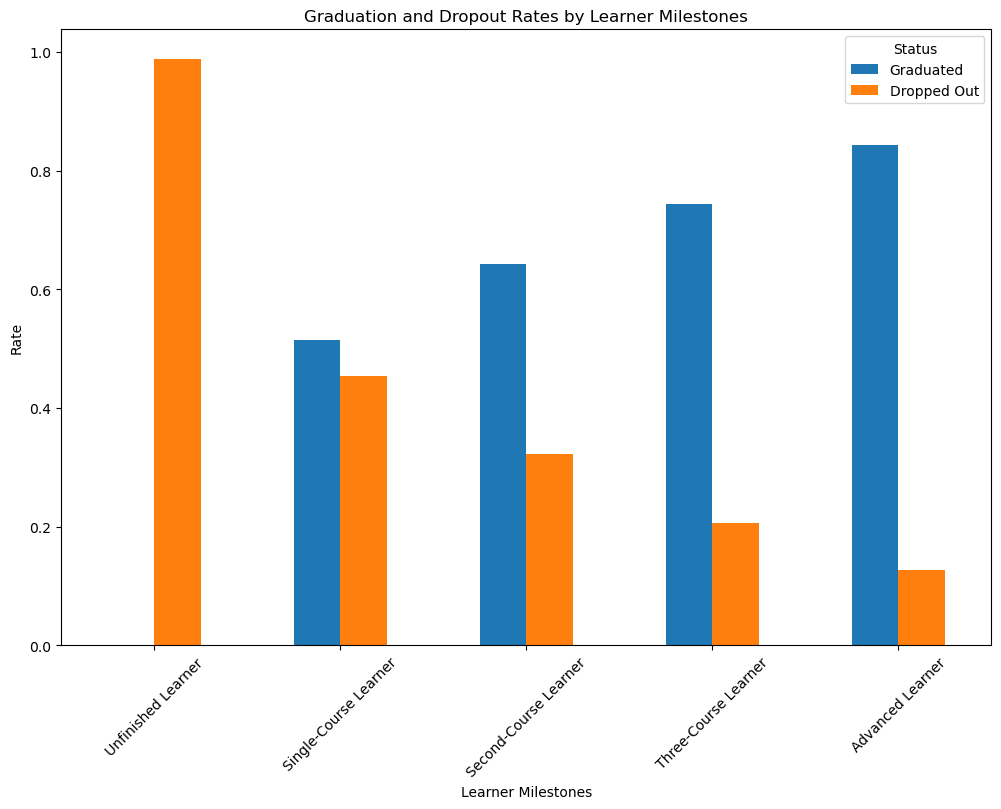

In [46]:
# Preparing data for plotting
milestones_grad_drop_rates = true_student_status_distribution[['Graduated', 'Dropped Out']].loc[
    ['Unfinished Learner', 'Single-Course Learner', 'Second-Course Learner', 'Three-Course Learner', 'Advanced Learner']
]
# Plotting the graduation and dropout rates by learner milestones
fig, ax = plt.subplots(figsize=(12, 8))

milestones_grad_drop_rates.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Graduation and Dropout Rates by Learner Milestones')
ax.set_ylabel('Rate')
ax.set_xlabel('Learner Milestones')
ax.legend(title='Status')
plt.xticks(rotation=45)
plt.show()

In [55]:
# Calculating distribution for reengagment dynamics
dynamics_distribution = calculate_distribution('reengagment_dynamics', distribution_columns)

# Displaying the distribution for 'level', 'function', 'industry', and 'true_student_status' for reengagment dynamics
level_dynamics_distribution = dynamics_distribution['level']
function_dynamics_distribution = dynamics_distribution['function']
industry_dynamics_distribution = dynamics_distribution['industry']
duration_dynamics_distribution = dynamics_distribution['duration']
true_student_status_dynamics_distribution = dynamics_distribution['true_student_status']

level_dynamics_distribution, function_dynamics_distribution, industry_dynamics_distribution, true_student_status_dynamics_distribution, duration_dynamics_distribution


(level                            C-Level  C-Level (CEO, COO, CTO, etc.)  \
 reengagment_dynamics                                                      
 Currently Enrolled    0.355398  0.000000                       0.005141   
 Fast Movers           0.087106  0.000000                       0.006567   
 Intermediate Movers   0.094975  0.000000                       0.013480   
 Moderate Movers       0.098808  0.000000                       0.010038   
 No re-enrollment      0.257466  0.000022                       0.010049   
 Slow Movers           0.116178  0.000000                       0.007429   
 
 level                 Individual Contributor     Other  \
 reengagment_dynamics                                     
 Currently Enrolled                  0.105398  0.000000   
 Fast Movers                         0.134242  0.000067   
 Intermediate Movers                 0.129902  0.000000   
 Moderate Movers                     0.120765  0.000000   
 No re-enrollment                   

In [56]:
duration_dynamics_distribution

duration,1.0,3.0,6.0
reengagment_dynamics,,,
Currently Enrolled,0.287243,0.269136,0.443621
Fast Movers,0.864800,0.096691,0.038508
Intermediate Movers,0.828169,0.104225,0.067606
Moderate Movers,0.812611,0.102601,0.084788
No re-enrollment,0.737469,0.147887,0.114645
Slow Movers,0.770071,0.179081,0.050847


# Reengagement Dynamics Analysis

## Professional Level Distribution

- **Senior Manager/Manager** and **Senior Director/Director** are prominent across all dynamics, highlighting their active engagement in learning activities.
- **C-Level** roles, while present, make up a smaller proportion in each category, approximately ranging from 0.7% to 1.4%.

## Function Distribution

- Functions such as **Operations**, **Sales & Service**, and **General Management** are notably frequent across the dynamics.
  - **Operations** is especially significant in the "Fast Movers" group.
  - **Finance** and **Marketing & Communications** are also noteworthy, particularly in "Fast Movers" and "Moderate Movers".

## Industry Distribution

- **Business Services** and **Technology** are key industries across most dynamics.
  - The "Currently Enrolled" category shows exceptionally high engagement from the **Healthcare and Pharma** industry.
  - **Manufacturing** and **Retail** are visible to varying extents in each category.

## True Student Status (Graduation Rate)

- **Fast Movers**:
  - **Graduated**: 93.36%
  - **Dropped Out**: 4.14%
- **Intermediate Movers**:
  - **Graduated**: 87.07%
  - **Dropped Out**: 9.68%
- **Moderate Movers**:
  - **Graduated**: 89.37%
  - **Dropped Out**: 7.31%
- **No re-enrollment**:
  - **Graduated**: 43.31%
  - **Dropped Out**: 56.16%
- **Slow Movers**:
  - **Graduated**: 55.28%
  - **Dropped Out**: 43.58%
- **Currently Enrolled**:
  - **Enrolled**: 100% (Ongoing courses, graduation status is not applicable yet.)

## Insights

- **High Graduation Rates** among "Fast Movers", "Intermediate Movers", and "Moderate Movers" indicate that quicker progression through learning activities correlates with higher completion rates.
- **Significant Dropout Rates** in "No re-enrollment" and "Slow Movers" suggest challenges in maintaining engagement or satisfaction with courses.
- The distribution of high-level professionals and key industries in these active learning groups underscores the importance of tailored learning solutions for these demographics to enhance engagement and completion rates.


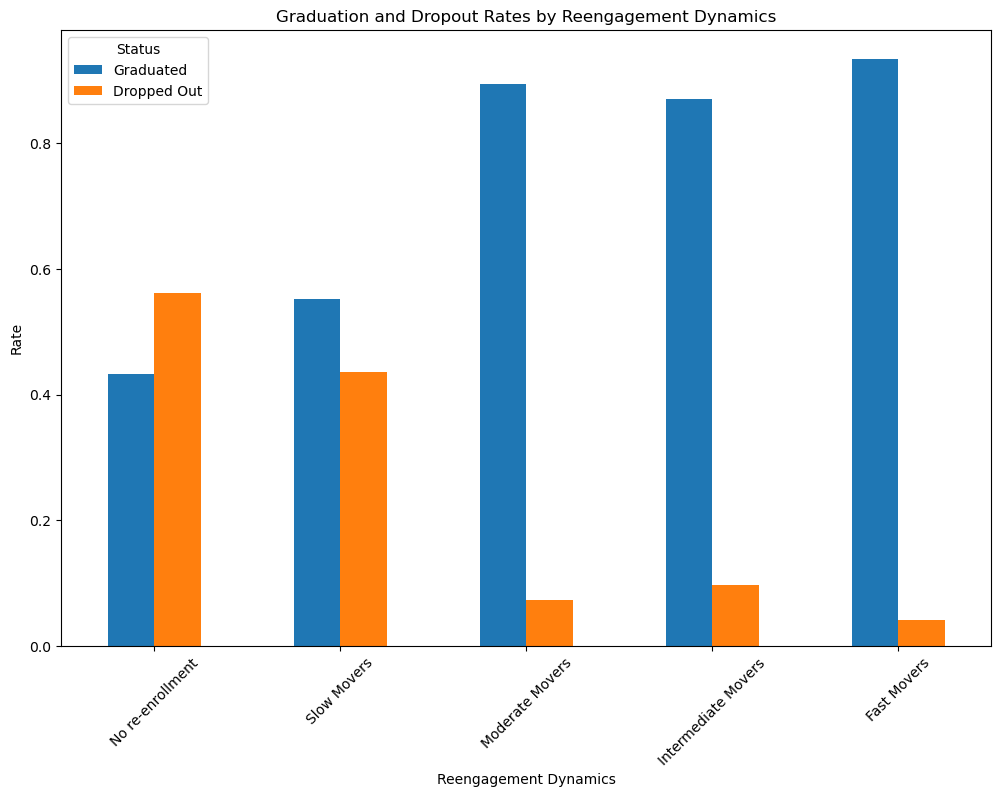

In [48]:
# Preparing data for plotting
grad_drop_rates = true_student_status_dynamics_distribution[['Graduated', 'Dropped Out']].loc[
    ['No re-enrollment', 'Slow Movers', 'Moderate Movers', 'Intermediate Movers', 'Fast Movers']
]

# Plotting the graduation and dropout rates by reengagement dynamics
fig, ax = plt.subplots(figsize=(12, 8))

grad_drop_rates.plot(kind='bar', stacked=False, ax=ax)
ax.set_title('Graduation and Dropout Rates by Reengagement Dynamics')
ax.set_ylabel('Rate')
ax.set_xlabel('Reengagement Dynamics')
ax.legend(title='Status')
plt.xticks(rotation=45)
plt.show()


In [53]:
# Grouping the data by 'learner_milestones' and calculating the mean for selected metrics
milestones_grouped = data.groupby('learner_milestones')[['percent_complete', 'days_till_next_activity', 'completed_on_time']].mean()

# Display the grouped data
milestones_grouped


/var/folders/2n/ck9mn70j5q7gkngs4bpqc6w00000gq/T/ipykernel_82146/3096263117.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  milestones_grouped = data.groupby('learner_milestones')[['percent_complete', 'days_till_next_activity', 'completed_on_time']].mean()


,percent_complete,days_till_next_activity
learner_milestones,,
Advanced Learner,83.365870,24.959013
Second-Course Learner,70.809571,57.112825
Single-Course Learner,63.328890,17.671024
Three-Course Learner,77.448316,35.412661
Unfinished Learner,24.302216,123.335404


In [54]:
# Grouping the data by 'reengagment_dynamics' and calculating the mean for selected metrics
dynamics_grouped = data.groupby('reengagment_dynamics')[['percent_complete', 'days_till_next_activity', 'completed_on_time']].mean()

# Display the grouped data
dynamics_grouped


/var/folders/2n/ck9mn70j5q7gkngs4bpqc6w00000gq/T/ipykernel_82146/1474862790.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dynamics_grouped = data.groupby('reengagment_dynamics')[['percent_complete', 'days_till_next_activity', 'completed_on_time']].mean()


,percent_complete,days_till_next_activity
reengagment_dynamics,,
Currently Enrolled,18.011305,NaN
Fast Movers,90.132784,4.607874
Intermediate Movers,85.699072,74.401961
Moderate Movers,87.431778,42.706085
No re-enrollment,56.285684,NaN
Slow Movers,65.433993,184.079447


## Learner Milestones Grouped Analysis

| Learner Milestone       | Percent Complete | Days Till Next Activity | Completed on Time |
|-------------------------|------------------|-------------------------|-------------------|
| Advanced Learner        | 83.37%           | 25 days                 | 49.22%            |
| Second-Course Learner   | 70.81%           | 57 days                 | 31.41%            |
| Single-Course Learner   | 63.33%           | 18 days                 | 20.44%            |
| Three-Course Learner    | 77.45%           | 35 days                 | 40.44%            |
| Unfinished Learner      | 24.30%           | 123 days                | 0.01%             |

### Insights
- **Advanced Learners** and **Three-Course Learners** generally complete a higher percentage of their courses and have better on-time completion rates compared to others.
- **Unfinished Learners** have very low completion rates and significantly longer periods of inactivity, which might indicate disengagement or challenges with the course material.
- The **Days Till Next Activity** is shortest for **Single-Course Learners**, suggesting they may engage more frequently but possibly in shorter courses or less comprehensive content.

## Reengagement Dynamics Grouped Analysis

| Reengagement Dynamics   | Percent Complete | Days Till Next Activity | Completed on Time |
|-------------------------|------------------|-------------------------|-------------------|
| Currently Enrolled      | 18.01%           | N/A                     | 2.31%             |
| Fast Movers             | 90.13%           | 5 days                  | 51.13%            |
| Intermediate Movers     | 85.70%           | 74 days                 | 49.63%            |
| Moderate Movers         | 87.43%           | 43 days                 | 48.90%            |
| No re-enrollment        | 56.29%           | N/A                     | 21.33%            |
| Slow Movers             | 65.43%           | 184 days                | 28.39%            |

### Insights
- **Fast Movers** exhibit the highest course completion rates and shortest intervals until the next activity, indicating high engagement and potentially successful course designs or student commitment.
- **Slow Movers** have longer intervals until their next activity, which might indicate challenges in maintaining engagement or difficulties with course material.
- The **No re-enrollment** group shows moderate course completion percentages and lower completion rates, suggesting possible areas for intervention to improve retention and engagement.
